## Nested Grid Problem, Two Domains

This example shows how the MODFLOW 6 GWF-GWF Exchange can be used to simulate
a nested grid problem. The example corresponds to the first example
described in the MODFLOW-USG documentation. Instead of the ghost node feature,
we use the XT3D option in the NPF package to improve the accuracy at the
interface between the models.

The problem is run for three different scenarios:

1. without XT3D enabled in the NPF package
2. with XT3D enabled in both models
3. with XT3D enabled in both models and at the interface
4. with XT3D enabled _only_ at the interface between the models

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from flopy.utils.lgrutil import Lgr
from matplotlib.colors import ListedColormap
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Scenario-specific parameters
parameters = {
    "ex-gwf-u1gwfgwf-s1": {
        "XT3D_in_models": False,
        "XT3D_at_exchange": False,
    },
    "ex-gwf-u1gwfgwf-s2": {
        "XT3D_in_models": True,
        "XT3D_at_exchange": False,
    },
    "ex-gwf-u1gwfgwf-s3": {
        "XT3D_in_models": True,
        "XT3D_at_exchange": True,
    },
    "ex-gwf-u1gwfgwf-s4": {
        "XT3D_in_models": False,
        "XT3D_at_exchange": True,
    },
}

# Model parameters
nper = 1  # Number of periods
nlay = 1  # Number of layers
top = 0.0  # Top of the model ($m$)
botm = -100.0  # Layer bottom elevations ($m$)
strt = 0.0  # Starting head ($m$)
h_left = 1.0  # Constant head boundary LEFT ($m$)
h_right = 0.0  # Constant head boundary RIGHT ($m$)
icelltype = 0  # Cell conversion type
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)

# Static temporal data used by TDIS file
# Simulation has 1 steady stress period (1 day)
# with 1 time step
perlen = [1.0]
nstp = [1]
tsmult = [1.0, 1.0, 1.0]
tdis_ds = list(zip(perlen, nstp, tsmult))

# Coarse model grid
nlay = 1
nrow = ncol = 7
delr = 100.0
delc = 100.0
tp = 0.0
bt = -100.0
idomain = np.ones((nlay, nrow, ncol))
idomain[:, 2:5, 2:5] = 0
gwfname_outer = "outer"

# Refined model grid
rfct = 3
nrow_inner = ncol_inner = 9
delr_inner = 100.0 / rfct
delc_inner = 100.0 / rfct
idomain_inner = np.ones((nlay, nrow_inner, ncol_inner))
xorigin = 200.0
yorigin = 200.0
gwfname_inner = "inner"

# Solver parameters
nouter = 50
ninner = 100
hclose = 1e-9
rclose = 1e-6

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(sim_name, XT3D_in_models, XT3D_at_exchange):
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        linear_acceleration="bicgstab",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )

    # The coarse, outer model
    gwf_outer = flopy.mf6.ModflowGwf(sim, modelname=gwfname_outer, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf_outer,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        idomain=idomain,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf_outer,
        icelltype=icelltype,
        k=k11,
        save_specific_discharge=True,
        xt3doptions=XT3D_in_models,
    )
    flopy.mf6.ModflowGwfic(gwf_outer, strt=strt)

    # constant head boundary LEFT
    left_chd = [
        [(ilay, irow, 0), h_left] for ilay in range(nlay) for irow in range(nrow)
    ]
    chd_spd = {0: left_chd}
    flopy.mf6.ModflowGwfchd(
        gwf_outer,
        stress_period_data=chd_spd,
        pname="CHD-LEFT",
        filename=f"{gwfname_outer}.left.chd",
    )

    # constant head boundary RIGHT
    right_chd = [
        [(ilay, irow, ncol - 1), h_right]
        for ilay in range(nlay)
        for irow in range(nrow)
    ]
    chd_spd = {0: right_chd}
    flopy.mf6.ModflowGwfchd(
        gwf_outer,
        stress_period_data=chd_spd,
        pname="CHD-RIGHT",
        filename=f"{gwfname_outer}.right.chd",
    )

    head_filerecord = f"{gwfname_outer}.hds"
    budget_filerecord = f"{gwfname_outer}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf_outer,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    # the refined, inner model
    gwf_inner = flopy.mf6.ModflowGwf(sim, modelname=gwfname_inner, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf_inner,
        nlay=nlay,
        nrow=nrow_inner,
        ncol=ncol_inner,
        delr=delr_inner,
        delc=delc_inner,
        top=top,
        botm=botm,
        xorigin=xorigin,
        yorigin=yorigin,
        length_units=length_units,
    )
    flopy.mf6.ModflowGwfic(gwf_inner, strt=strt)
    flopy.mf6.ModflowGwfnpf(
        gwf_inner,
        save_specific_discharge=True,
        xt3doptions=XT3D_in_models,
        save_flows=True,
        icelltype=icelltype,
        k=k11,
    )

    head_filerecord = f"{gwfname_inner}.hds"
    budget_filerecord = f"{gwfname_inner}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf_inner,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    # Use Lgr to get the exchange data
    nrowp = gwf_outer.dis.nrow.get_data()
    ncolp = gwf_outer.dis.ncol.get_data()
    delrp = gwf_outer.dis.delr.array
    delcp = gwf_outer.dis.delc.array
    topp = gwf_outer.dis.top.array
    botmp = gwf_outer.dis.botm.array
    idomainp = gwf_outer.dis.idomain.array

    lgr = Lgr(
        nlay,
        nrowp,
        ncolp,
        delrp,
        delcp,
        topp,
        botmp,
        idomainp,
        ncpp=rfct,
        ncppl=1,
    )

    exgdata = lgr.get_exchange_data(angldegx=True, cdist=True)
    for exg in exgdata:
        l = exg
        angle = l[-2]
        if angle == 0:
            bname = "left"
        elif angle == 90.0:
            bname = "bottom"
        elif angle == 180.0:
            bname = "right"
        elif angle == 270.0:
            bname = "top"
        l.append(bname)

    # group exchanges based on boundname
    exgdata.sort(key=lambda x: x[-3])

    flopy.mf6.ModflowGwfgwf(
        sim,
        exgtype="GWF6-GWF6",
        nexg=len(exgdata),
        exgmnamea=gwfname_outer,
        exgmnameb=gwfname_inner,
        exchangedata=exgdata,
        xt3d=XT3D_at_exchange,
        print_input=True,
        print_flows=True,
        save_flows=True,
        boundnames=True,
        auxiliary=["ANGLDEGX", "CDIST"],
    )

    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=False):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (5, 5)
figure_size_double = (7, 3)


def plot_grid(idx, sim):
    with styles.USGSMap() as fs:
        sim_name = list(parameters.keys())[idx]
        gwf_outer = sim.get_model(gwfname_outer)
        gwf_inner = sim.get_model(gwfname_inner)

        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf_outer, ax=ax, layer=0)
        pmv_inner = flopy.plot.PlotMapView(model=gwf_inner, ax=ax, layer=0)

        pmv.plot_grid()
        pmv_inner.plot_grid()

        pmv.plot_bc(name="CHD-LEFT", alpha=0.75)
        pmv.plot_bc(name="CHD-RIGHT", alpha=0.75)

        ax.plot(
            [200, 500, 500, 200, 200],
            [200, 200, 500, 500, 200],
            "r--",
            linewidth=2.0,
        )

        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)


def plot_stencils(idx, sim):
    with styles.USGSMap() as fs:
        sim_name = list(parameters.keys())[idx]
        gwf_outer = sim.get_model(gwfname_outer)
        gwf_inner = sim.get_model(gwfname_inner)

        fig = plt.figure(figsize=figure_size_double)
        fig.tight_layout()

        # left plot, with stencils at the interface
        ax = fig.add_subplot(1, 2, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf_outer, ax=ax, layer=0)
        pmv_inner = flopy.plot.PlotMapView(
            model=gwf_inner, ax=ax, layer=0, extent=pmv.extent
        )
        pmv.plot_grid()
        pmv_inner.plot_grid()

        stencil = np.zeros(pmv.mg.shape, dtype=int)
        stencil_inner = np.zeros(pmv_inner.mg.shape, dtype=int)

        # stencil 1
        stencil[0, 0, 3] = 1
        stencil[0, 1, 2] = 1
        stencil[0, 1, 3] = 1
        stencil[0, 1, 4] = 1
        stencil_inner[0, 0, 3] = 1
        stencil_inner[0, 0, 4] = 1
        stencil_inner[0, 0, 5] = 1
        stencil_inner[0, 1, 4] = 1

        # stencil 2
        stencil[0, 4, 1] = 1
        stencil[0, 5, 1] = 1
        stencil[0, 5, 2] = 1
        stencil[0, 5, 3] = 1
        stencil[0, 6, 2] = 1
        stencil_inner[0, 7, 0] = 1
        stencil_inner[0, 8, 0] = 1
        stencil_inner[0, 8, 1] = 1

        # markers
        x = [350.0, 216.666]
        y = [500.0, 200.0]

        stencil = np.ma.masked_equal(stencil, 0)
        stencil_inner = np.ma.masked_equal(stencil_inner, 0)
        cmap = ListedColormap(["dodgerblue"])
        pmv.plot_array(stencil, cmap=cmap)
        pmv_inner.plot_array(stencil_inner, cmap=cmap)
        plt.scatter(x, y, facecolors="r")

        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")

        # right plot, with stencils '1 connection away from the interface'
        ax = fig.add_subplot(1, 2, 2, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf_outer, ax=ax, layer=0)
        pmv_inner = flopy.plot.PlotMapView(
            model=gwf_inner, ax=ax, layer=0, extent=pmv.extent
        )
        pmv.plot_grid()
        pmv_inner.plot_grid()

        stencil = np.zeros(pmv.mg.shape, dtype=int)
        stencil_inner = np.zeros(pmv_inner.mg.shape, dtype=int)

        # stencil 1
        stencil[0, 0, 1] = 1
        stencil[0, 1, 1] = 1
        stencil[0, 1, 2] = 1
        stencil[0, 1, 0] = 1
        stencil[0, 2, 1] = 1
        stencil[0, 2, 0] = 1
        stencil[0, 3, 1] = 1
        stencil_inner[0, 0, 0] = 1
        stencil_inner[0, 1, 0] = 1
        stencil_inner[0, 2, 0] = 1

        # stencil 2
        stencil_inner[0, 6, 7] = 1
        stencil_inner[0, 7, 6] = 1
        stencil_inner[0, 7, 7] = 1
        stencil_inner[0, 7, 8] = 1
        stencil_inner[0, 8, 6] = 1
        stencil_inner[0, 8, 7] = 1
        stencil_inner[0, 8, 8] = 1
        stencil[0, 5, 4] = 1

        # markers
        x = [150.0, 450.0]
        y = [500.0, 233.333]

        stencil = np.ma.masked_equal(stencil, 0)
        stencil_inner = np.ma.masked_equal(stencil_inner, 0)
        cmap = ListedColormap(["dodgerblue"])
        pmv.plot_array(stencil, cmap=cmap)
        pmv_inner.plot_array(stencil_inner, cmap=cmap)
        plt.scatter(x, y, facecolors="r")

        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-stencils.png"
            fig.savefig(fpth)


def plot_head(idx, sim):
    with styles.USGSMap() as fs:
        sim_name = list(parameters.keys())[idx]
        gwf_outer = sim.get_model(gwfname_outer)
        gwf_inner = sim.get_model(gwfname_inner)

        fig = plt.figure(figsize=figure_size_double)
        fig.tight_layout()

        head = gwf_outer.output.head().get_data()[0]
        head_inner = gwf_inner.output.head().get_data()[0]
        head[head == 1e30] = np.nan
        head_inner[head_inner == 1e30] = np.nan

        # create MODFLOW 6 cell-by-cell budget objects
        qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
            gwf_outer.output.budget().get_data(text="DATA-SPDIS", totim=1.0)[0],
            gwf_outer,
        )
        (
            qx_inner,
            qy_inner,
            qz_inner,
        ) = flopy.utils.postprocessing.get_specific_discharge(
            gwf_inner.output.budget().get_data(text="DATA-SPDIS", totim=1.0)[0],
            gwf_inner,
        )

        # create plot with head values and spdis
        ax = fig.add_subplot(1, 2, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf_outer, ax=ax, layer=0)
        pmv_inner = flopy.plot.PlotMapView(
            model=gwf_inner, ax=ax, layer=0, extent=pmv.extent
        )
        cb = pmv.plot_array(head, cmap="jet", vmin=0.0, vmax=1.0)
        cb = pmv_inner.plot_array(head_inner, cmap="jet", vmin=0.0, vmax=1.0)
        pmv.plot_grid()
        pmv_inner.plot_grid()
        pmv.plot_vector(
            qx,
            qy,
            normalize=False,
            color="0.75",
        )
        pmv_inner.plot_vector(
            qx_inner,
            qy_inner,
            normalize=False,
            color="0.75",
        )
        cbar = plt.colorbar(cb, shrink=0.25)
        cbar.ax.set_xlabel(r"Head, ($m$)")
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        styles.heading(ax, letter="A", heading="Simulated Head")

        # create plot with error in head
        ax = fig.add_subplot(1, 2, 2, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf_outer, ax=ax, layer=0)
        pmv_inner = flopy.plot.PlotMapView(
            model=gwf_inner, ax=ax, layer=0, extent=pmv.extent
        )
        pmv.plot_grid()
        pmv_inner.plot_grid()
        x = np.array(gwf_outer.modelgrid.xcellcenters) - 50.0
        x_inner = np.array(gwf_inner.modelgrid.xcellcenters) - 50.0
        slp = (h_left - h_right) / (50.0 - 650.0)
        head_exact = slp * x + h_left
        head_exact_inner = slp * x_inner + h_left
        err = head - head_exact
        err_inner = head_inner - head_exact_inner
        vmin = min(np.nanmin(err), np.nanmin(err_inner))
        vmax = min(np.nanmax(err), np.nanmax(err_inner))
        cb = pmv.plot_array(err, cmap="jet", vmin=vmin, vmax=vmax)
        cb = pmv_inner.plot_array(err_inner, cmap="jet", vmin=vmin, vmax=vmax)

        cbar = plt.colorbar(cb, shrink=0.25)
        cbar.ax.set_xlabel(r"Error, ($m$)")
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        styles.heading(ax, letter="B", heading="Error")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-head.png"
            fig.savefig(fpth)


def plot_results(idx, sim, silent=True):
    if idx == 0:
        plot_grid(idx, sim)
        plot_stencils(idx, sim)
    plot_head(idx, sim)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [5]:
def simulation(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_models(key, **params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(idx, sim, silent=silent)

Run without XT3D, then plot simulated heads.

run_models took 51.83 ms


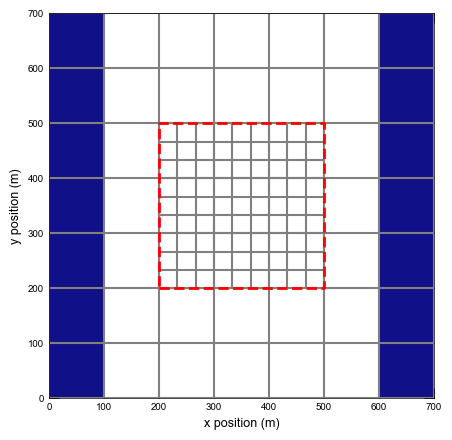

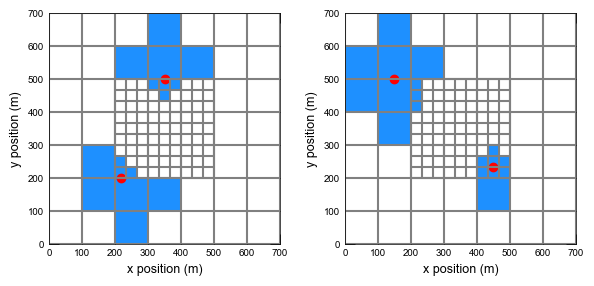

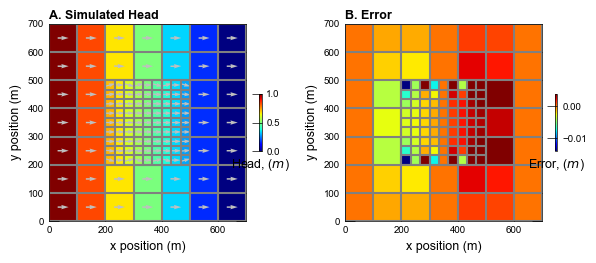

In [6]:
simulation(0)

Run with XT3D enabled globally, but not at the exchange, then plot simulated heads.

run_models took 55.01 ms


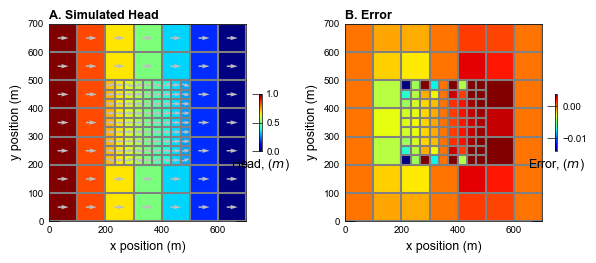

In [7]:
simulation(1)

Run with XT3D enabled globally, then plot simulated heads.

run_models took 84.26 ms


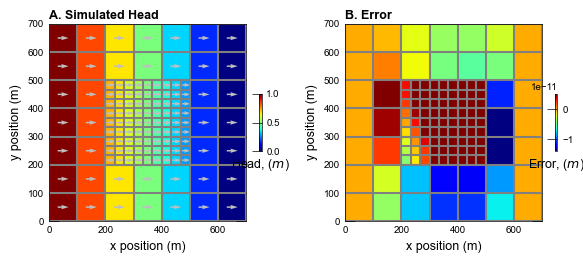

In [8]:
simulation(2)

Run with XT3D enabled _only_ at the model interface, then plot simulated heads.

run_models took 80.72 ms


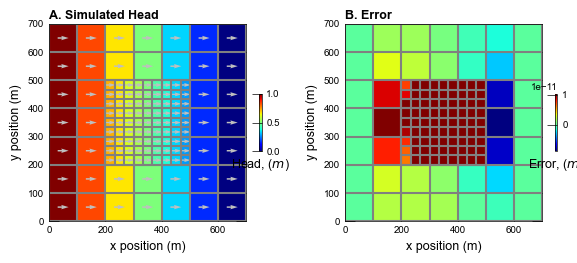

In [9]:
simulation(3)